In [394]:
import os
dataset_directory = '.\Data'
datasets = [(path, files) for path, _, files in os.walk(dataset_directory) if len(files) > 0]
trace_out = False
if trace_out:
    datasets

In [395]:
import matplotlib.image as mpimg
from skimage.transform import resize, rescale

imgs = [mpimg.imread(dn+'\\'+fn) for (dn,fns) in datasets for fn in fns]

print('Resizing...')
if trace_out:
    for img in imgs_128: print(img.shape)
augment_imgs = False
if augment_imgs:
    imgs = [crop(img, ((5,0),(3,2),(0,0))) for img in imgs]
imgs_128 = [resize(img, (128,128), anti_aliasing=True) for img in imgs]

print('Done resizing.')
if trace_out:
    for img in imgs_128: print(img.shape)

In [396]:
import math
def shift_hsv(hsv, shift_h, shift_v=0.0):
    h_new = hsv[0] + shift_h
    if (h_new > 1.0):
        h_new = h_new - 1.0
    v_new = hsv[2] + shift_v
    v_new = min(v_new, 1.0)
    v_new = max(v_new, 0.0)
    return [h_new,hsv[1],v_new]
    # return [v_new]
print(shift_hsv([0.9,0.3,0.5], 0.39, shift_v=0.1))

[0.29000000000000004, 0.3, 0.6]


In [397]:
%matplotlib inline
from matplotlib import colors
import matplotlib.pyplot as plt
from skimage.util import crop, pad
import numpy as np

UseColor = False
if UseColor:
    x_train = []
    fig, axes = plt.subplots(2,min(len(imgs_128),10),sharey=True, figsize=(18,5))
    for shift_h in range(1):
        for n in range(len(imgs_128)):
            img_hsv = colors.rgb_to_hsv(imgs_128[n])
            img_hsv = np.apply_along_axis(shift_hsv, 2, img_hsv, shift_h=shift_h/1.0, shift_v=0.0)
            img_hsv = np.clip(img_hsv, 0.0, 1.0)
            x_train.append(img_hsv)
            # print(img_hsv.shape)
            if n < min(len(imgs_128),10):
                axes[shift_h][n].imshow(colors.hsv_to_rgb(img_hsv))

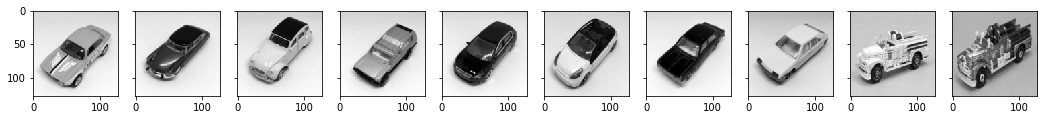

In [398]:
# BLACKnWHITE
x_train = []
fig, axes = plt.subplots(1,min(len(imgs_128),10),sharey=True, figsize=(18,5))
for n in range(len(imgs_128)):
    img_bw = imgs_128[n][...,0]
    img_bw = np.clip(img_bw, 0.0, 1.0)
    x_train.append(img_bw)
    if n < min(len(imgs_128),10):
        axes[n].imshow(img_bw, cmap='gray')

In [399]:
pre_stats = [(img.mean(), img.std()) for img in x_train]
pre_stats[1:5][:]

[(0.6765682380135152, 0.28001246595745494),
 (0.735976435667744, 0.2106681807682175),
 (0.7159432676492954, 0.1930435160719156),
 (0.6181787016527618, 0.31360166470396134)]

In [437]:
x_train_proc = \
    [np.clip(0.5 + (img - img.mean()) / (2.0*img.std()), 0.0, 1.0) for img in x_train]
x_train[0].shape, x_train_proc[0].shape

((128, 128), (128, 128))

In [438]:
x_train_proc = np.array(x_train_proc)
x_train_proc = x_train_proc.reshape(
                    x_train_proc.shape[0], 
                    x_train_proc.shape[1], 
                    x_train_proc.shape[2], 
                    1)
x_train_proc.shape # len(x_train), [data.shape for data in x_train]
# x_train[:,:,:,0:1].shape

(167, 128, 128, 1)

In [401]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

In [402]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [434]:
def build_autoencoder(sz, optimizer, loss):

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    # x = SpatialDropout2D(0.1)(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [435]:
vae, enc, dec = build_autoencoder(128, 'adadelta', 
                                      # 'categorical_crossentropy')
                                      'mean_squared_error')
                                      # 'binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 128, 128, 32) 320         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_61 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 64, 64, 32)   9248        max_pooling2d_61[0][0]           
__________________________________________________________________________________________________
max_poolin

In [439]:
import random
x_test = np.array(random.sample(list(x_train_proc), int(len(x_train_proc)/10)))
x_train_proc.shape, x_test.shape

((167, 128, 128, 1), (16, 128, 128, 1))

In [440]:
vae.fit(x_train_proc, x_train_proc, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Train on 167 samples, validate on 16 samples
Epoch 1/1000
167/167 [==============================] - 13s 77ms/step - loss: 0.1162 - val_loss: 0.1281
Epoch 2/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1161 - val_loss: 0.1279
Epoch 3/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1158 - val_loss: 0.1277
Epoch 4/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1156 - val_loss: 0.1274
Epoch 5/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1153 - val_loss: 0.1271
Epoch 6/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1151 - val_loss: 0.1269
Epoch 7/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1149 - val_loss: 0.1267
Epoch 8/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1147 - val_loss: 0.1264
Epoch 9/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.1144 - val_loss: 0.1262
Epoch 10/1000
167/167 [============

Epoch 81/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0659
Epoch 82/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0658
Epoch 83/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0667
Epoch 84/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0654
Epoch 85/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0666
Epoch 86/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0645
Epoch 87/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0678
Epoch 88/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0657
Epoch 89/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0671
Epoch 90/1000
167/167 [==============================] - 0s 1ms/step - lo

Epoch 160/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0639
Epoch 161/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0657
Epoch 162/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0647
Epoch 163/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0660
Epoch 164/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0646
Epoch 165/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0646
Epoch 166/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0637
Epoch 167/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0654
Epoch 168/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0632
Epoch 169/1000
167/167 [==============================] - 0s 1ms

Epoch 239/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0651
Epoch 240/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0631
Epoch 241/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0643
Epoch 242/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0631
Epoch 243/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0641
Epoch 244/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0637
Epoch 245/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0655
Epoch 246/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0635
Epoch 247/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0657
Epoch 248/1000
167/167 [==============================] - 0s 1ms

Epoch 318/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0507 - val_loss: 0.0484
Epoch 319/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.0493
Epoch 320/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0504 - val_loss: 0.0480
Epoch 321/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0499
Epoch 322/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0497 - val_loss: 0.0479
Epoch 323/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0498 - val_loss: 0.0486
Epoch 324/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0477
Epoch 325/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0476
Epoch 326/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0491 - val_loss: 0.0482
Epoch 327/1000
167/167 [==============================] - 0s 1ms

Epoch 397/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0464 - val_loss: 0.0466
Epoch 398/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0464 - val_loss: 0.0458
Epoch 399/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 400/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.0449
Epoch 401/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.0455
Epoch 402/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0461 - val_loss: 0.0445
Epoch 403/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0460 - val_loss: 0.0453
Epoch 404/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0459 - val_loss: 0.0449
Epoch 405/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 406/1000
167/167 [==============================] - 0s 1ms

Epoch 476/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0410
Epoch 477/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0412
Epoch 478/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0434 - val_loss: 0.0413
Epoch 479/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0437 - val_loss: 0.0423
Epoch 480/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0439 - val_loss: 0.0414
Epoch 481/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0437 - val_loss: 0.0423
Epoch 482/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0409
Epoch 483/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0436 - val_loss: 0.0425
Epoch 484/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0437 - val_loss: 0.0410
Epoch 485/1000
167/167 [==============================] - 0s 1ms

Epoch 555/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0377
Epoch 556/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0372
Epoch 557/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0385
Epoch 558/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0410 - val_loss: 0.0386
Epoch 559/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0419 - val_loss: 0.0415
Epoch 560/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0401
Epoch 561/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0440 - val_loss: 0.0418
Epoch 562/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0436 - val_loss: 0.0394
Epoch 563/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0400
Epoch 564/1000
167/167 [==============================] - 0s 1ms

Epoch 634/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 0.0355
Epoch 635/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0354
Epoch 636/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0353
Epoch 637/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0352
Epoch 638/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0349
Epoch 639/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0354
Epoch 640/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0350
Epoch 641/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0359
Epoch 642/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0350
Epoch 643/1000
167/167 [==============================] - 0s 1ms

Epoch 713/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0339
Epoch 714/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0340
Epoch 715/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0341
Epoch 716/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0343
Epoch 717/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0343
Epoch 718/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0344
Epoch 719/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0340
Epoch 720/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0347
Epoch 721/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0341
Epoch 722/1000
167/167 [==============================] - 0s 1ms

Epoch 792/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0322
Epoch 793/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0324
Epoch 794/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0319
Epoch 795/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0325
Epoch 796/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0322
Epoch 797/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0334
Epoch 798/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0331
Epoch 799/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0345
Epoch 800/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0335
Epoch 801/1000
167/167 [==============================] - 0s 1ms

Epoch 871/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0320
Epoch 872/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0343
Epoch 873/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0321
Epoch 874/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0340
Epoch 875/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0320
Epoch 876/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0343
Epoch 877/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0326
Epoch 878/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0343
Epoch 879/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0326
Epoch 880/1000
167/167 [==============================] - 0s 1ms

Epoch 950/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 951/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0319
Epoch 952/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0334
Epoch 953/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0313
Epoch 954/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0321
Epoch 955/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0308
Epoch 956/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0323
Epoch 957/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0312
Epoch 958/1000
167/167 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0319
Epoch 959/1000
167/167 [==============================] - 0s 1ms

In [430]:
print(x_test.shape)
encode_only_imgs = enc.predict(x_test)[2]   # z parameter is #2
print(encode_only_imgs.shape)

(16, 128, 128, 1)
(16, 16)


In [431]:
# for n in range(len(encode_only_imgs)):
print("shape of encoded = ", encode_only_imgs.shape)
print("encoded = ", encode_only_imgs)
hist, bins = np.histogram(encode_only_imgs)
print(hist)
print(bins)

# add random values to decoded
use_perturb = False
if use_perturb:    
    perturb_vectors = np.random.standard_normal(size=encode_only_imgs.shape)
    perturb_vectors = np.multiply(perturb_vectors, 1.6)
    encode_only_imgs_z = np.add(encode_only_imgs, perturb_vectors)
else:
    encode_only_imgs_z = encode_only_imgs
# encode_only_imgs_z = np.multiply(encode_only_imgs_z, 1.0)
decoded_imgs = dec.predict(encode_only_imgs_z)

shape of encoded =  (16, 16)
encoded =  [[ 2.29715099e+01  2.70929203e+01  9.34997845e+00 -2.33050747e+01
   2.91805077e+01  9.05087948e-01  3.64006653e+01  1.59301281e+01
   1.94202404e+01 -3.42220573e+01 -2.35063057e+01  7.69048405e+00
   7.00393772e+00 -7.57135201e+00 -3.49920201e+00 -3.09394588e+01]
 [-1.28861964e+00  1.99766216e+01 -7.60425091e+00 -1.74563541e+01
   1.74237900e+01  2.02801800e+01  4.34765129e+01  3.37767525e+01
  -7.50992727e+00 -3.62164230e+01  1.66448545e+00 -1.37033119e+01
  -5.93135071e+00  2.11652946e+01 -1.09177628e+01 -4.04432716e+01]
 [ 1.71735134e+01  2.06791935e+01  7.33900070e-01 -2.91190033e+01
   2.33073883e+01  2.97070146e+00  3.44289284e+01  2.86085453e+01
  -1.88410604e+00 -3.53397713e+01 -1.00857277e+01  1.72115341e-02
  -1.71891441e+01  2.78454947e+00  3.62507725e+00 -4.51497879e+01]
 [-8.31409645e+00  5.26415634e+00 -1.32561598e+01  8.34284878e+00
  -1.42722845e+01 -1.46517286e+01  1.80225487e+01 -3.95065193e+01
  -2.97836075e+01 -2.71503758e+00

In [432]:
print(x_test[0][64])
print(decoded_imgs[0][64])

[[0.80145551]
 [0.80145551]
 [0.78535792]
 [0.79299406]
 [0.79551717]
 [0.78469767]
 [0.79274646]
 [0.77227864]
 [0.8145348 ]
 [0.80145551]
 [0.79406697]
 [0.8095043 ]
 [0.79274646]
 [0.80942177]
 [0.81689284]
 [0.8095043 ]
 [0.74369127]
 [0.39521158]
 [0.01689476]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.51358542]
 [0.73460101]
 [0.83340308]
 [0.77515152]
 [0.65920647]
 [0.24047276]
 [0.        ]
 [0.11997668]
 [0.59333056]
 [0.84662778]
 [0.87389464]
 [0.88159758]
 [0.89157604]
 [0.86599519]
 [0.52661755]
 [0.26705185]
 [0.66676007]
 [0.86647073]
 [0.88933197]
 [0.88999222]
 [0.8247805 ]
 [0.37018094]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  

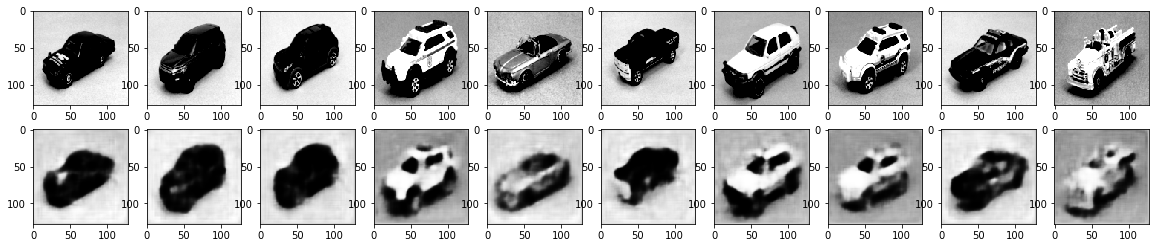

In [433]:
def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        # plt.imshow(colors.hsv_to_rgb(original[i].reshape(128, 128, 3)))     
        # re_original = original[i].reshape(128,128)
        plt.imshow(original[i].reshape(128,128), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(128, 128), cmap='gray')
        # plt.imshow(colors.hsv_to_rgb
        # (decoded[i].reshape(128, 128, 3)))
        # plt.imshow(colors.hsv_to_rgb(decode_this_image))
    plt.show() # block=True)
# decoded_imgs = vae.predict(x_test)
show_original_decoded(x_test, decoded_imgs, 128)